# Denoising CITE-seq protein data

In this tutorial, we go through steps for CITE-seq protein denoising using scAR. This dataset is downloaded from [10x genomics dataset](https://www.10xgenomics.com/resources/datasets/5-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-with-cell-surface-proteins-v-3-chemistry-3-1-standard-3-1-0), processed and annotation data is available at [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from matplotlib import pylab

params = {'legend.fontsize': 7,
          'legend.title_fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 432x324 with 0 Axes>

## read data

Original data were downloaded from [10xgenomics dataset](https://www.10xgenomics.com/resources/datasets/5-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-with-cell-surface-proteins-v-3-chemistry-3-1-standard-3-1-0). Cells were annotated using well-established markers, see the [manuscript](https://doi.org/10.1101/2022.01.14.476312) for details. For tutoring purpose, the processed file ([CITEseq_PBMCs_5k.h5ad](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data/)) is provided.

In [3]:
PBMCs5k = sc.read('../data/CITEseq_PBMCs_5k.h5ad')

visualization of cell types

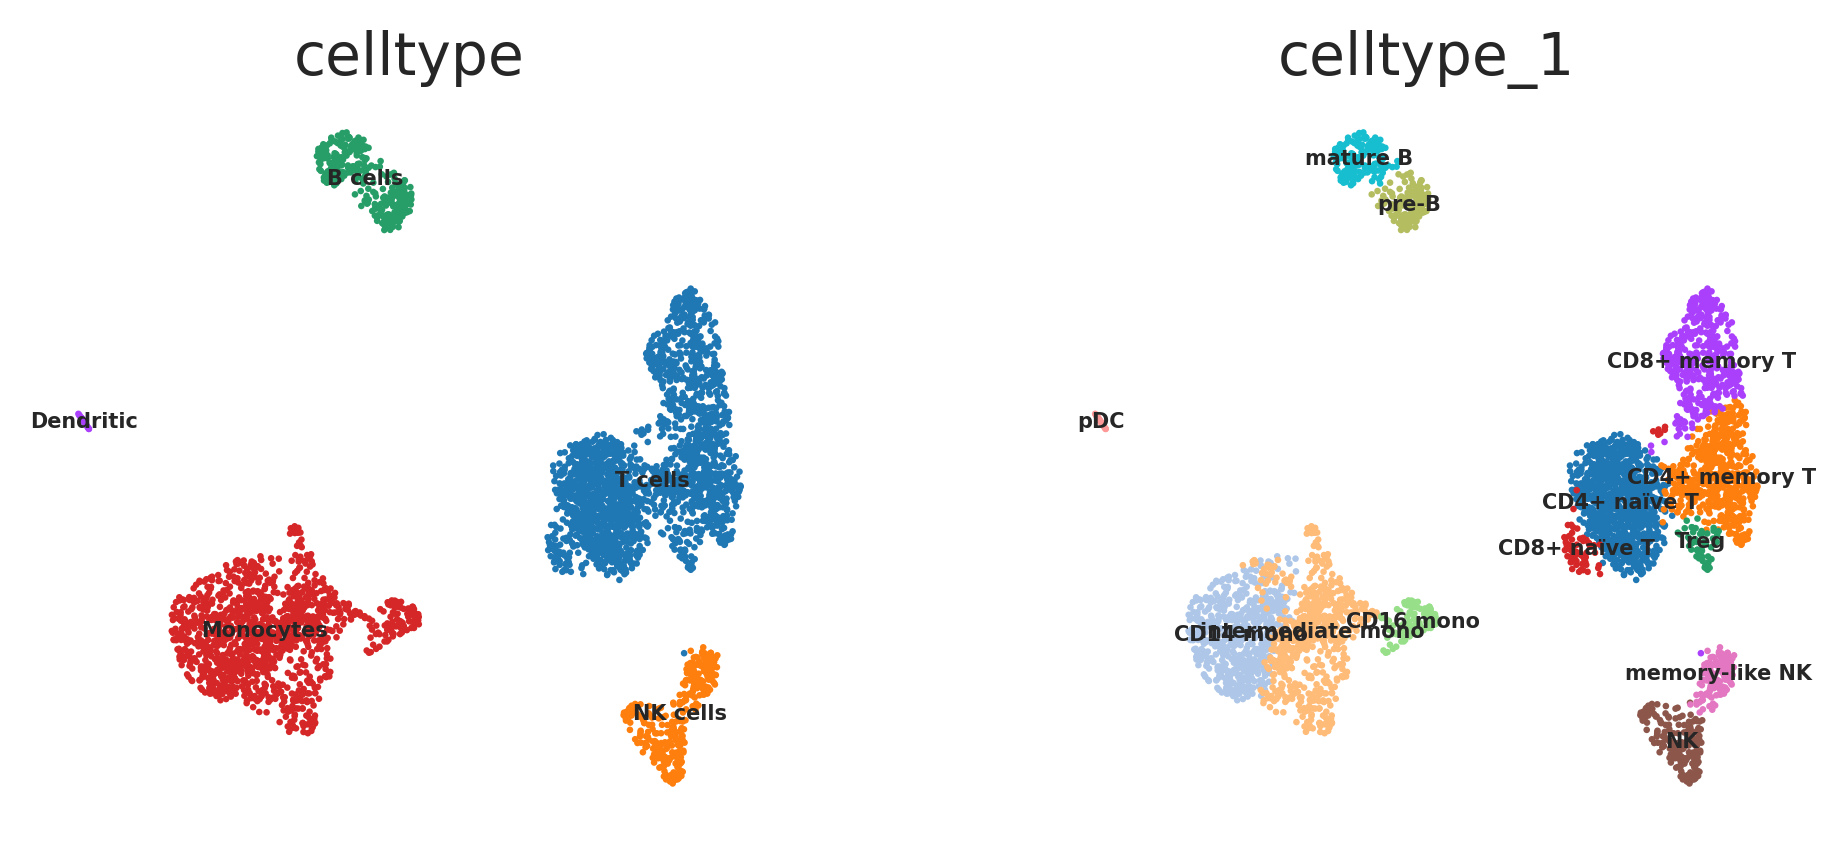

In [4]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3.1))
sc.pl.umap(PBMCs5k, size=10, color=["celltype", "celltype_1"],color_map="viridis",legend_loc="on data", frameon=False, legend_fontsize=5)

In [5]:
raw_ADT = PBMCs5k[:, PBMCs5k.var_names.str.endswith('_TotalSeqB')].to_df()
raw_ADT.columns = raw_ADT.columns.str.replace('_TotalSeqB','')

**Empty_profile is required in the CITEseq mode. Calculation of ambient_profile is a key to precise cleaning. Averaging pooled cells shows poor performance. We calculate this by averaging all cell-free droplets.**

In [6]:
ambient_profile = pd.read_pickle('../data/CITEseq_PBMCs_5k_ADT_ambient_profile.pickle')

In [7]:
# Train scAR
scarObj = scAR.model(raw_count=raw_ADT.values,
                     empty_profile=ambient_profile.values, # ambient profile is required for CITEseq
                     scRNAseq_tech='CITEseq')

scarObj.train(epochs=800,
              batch_size=64,
             )

# After training, we can infer the true protein signal
scarObj.inference()  # by defaut, batch_size=None, set a batch_size if getting GPU memory issue

..Running VAE using the following param set:
......scAR mode:  CITEseq
......num_input_feature:  32
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 800/800 [05:51<00:00,  2.27it/s]
  Inferring .....


In [8]:
denoised_ADT = pd.DataFrame(scarObj.native_counts, index=raw_ADT.index, columns=raw_ADT.columns)
denoised_ADT.columns = denoised_ADT.columns.str.replace('_TotalSeqB', '')

## Check results

### Boxplot of ADT counts per cell type

Visualization of ADT counts per cell type before and after denoising.

In [9]:
raw_ADT_stacked = np.log2(raw_ADT+1).stack().to_frame('log2(counts+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')   # log scale for visualization,
raw_ADT_stacked = raw_ADT_stacked.join(PBMCs5k.obs) # add cell type information
raw_ADT_stacked['count'] = 'raw'

denoised_ADT_stacked = np.log2(denoised_ADT+1).stack().to_frame('log2(counts+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')
denoised_ADT_stacked = denoised_ADT_stacked.join(PBMCs5k.obs)
denoised_ADT_stacked['count'] = 'denoised'

combined_ADTs = raw_ADT_stacked.append(denoised_ADT_stacked)

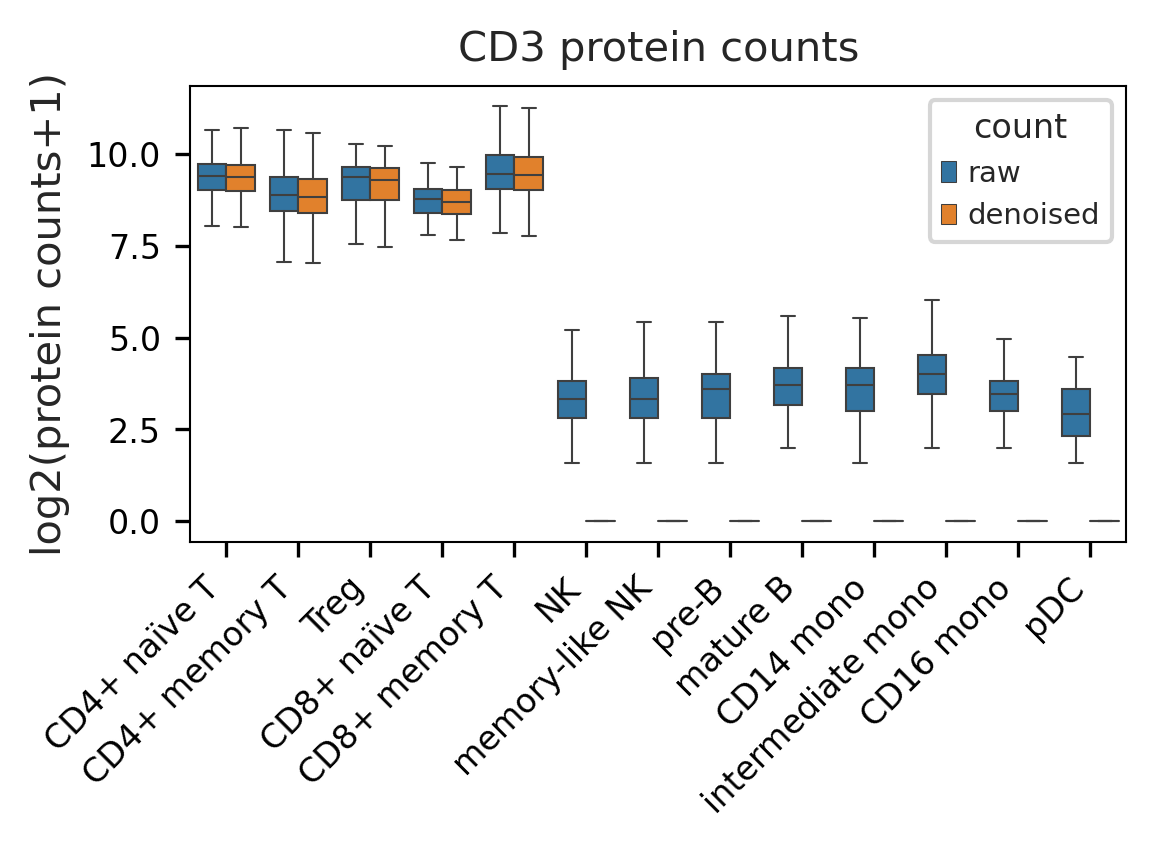

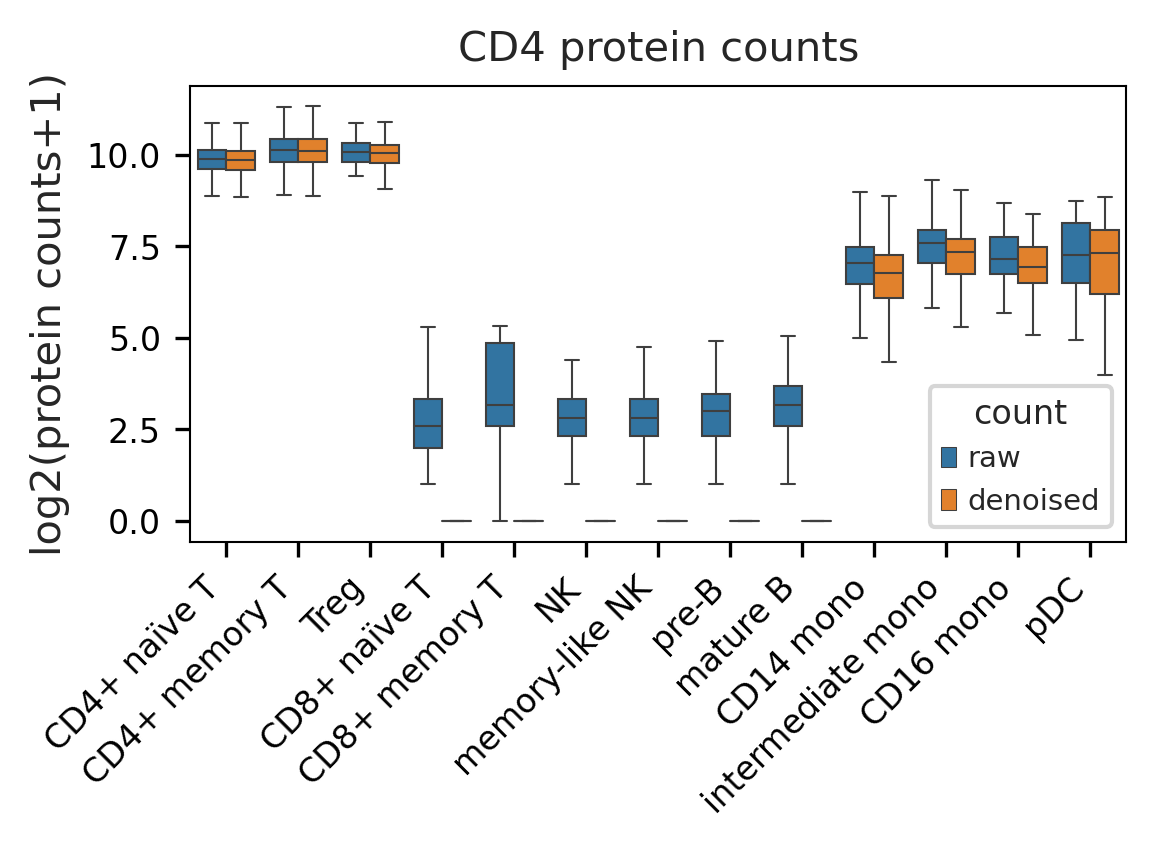

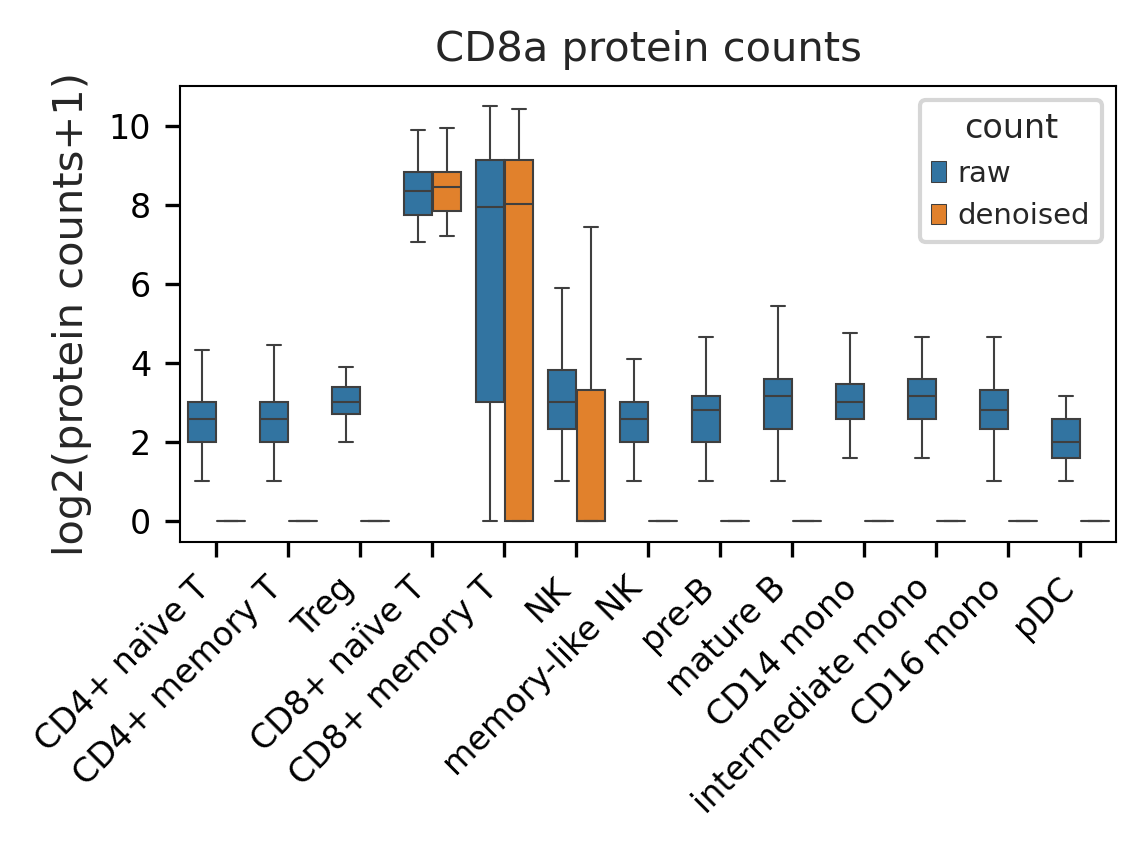

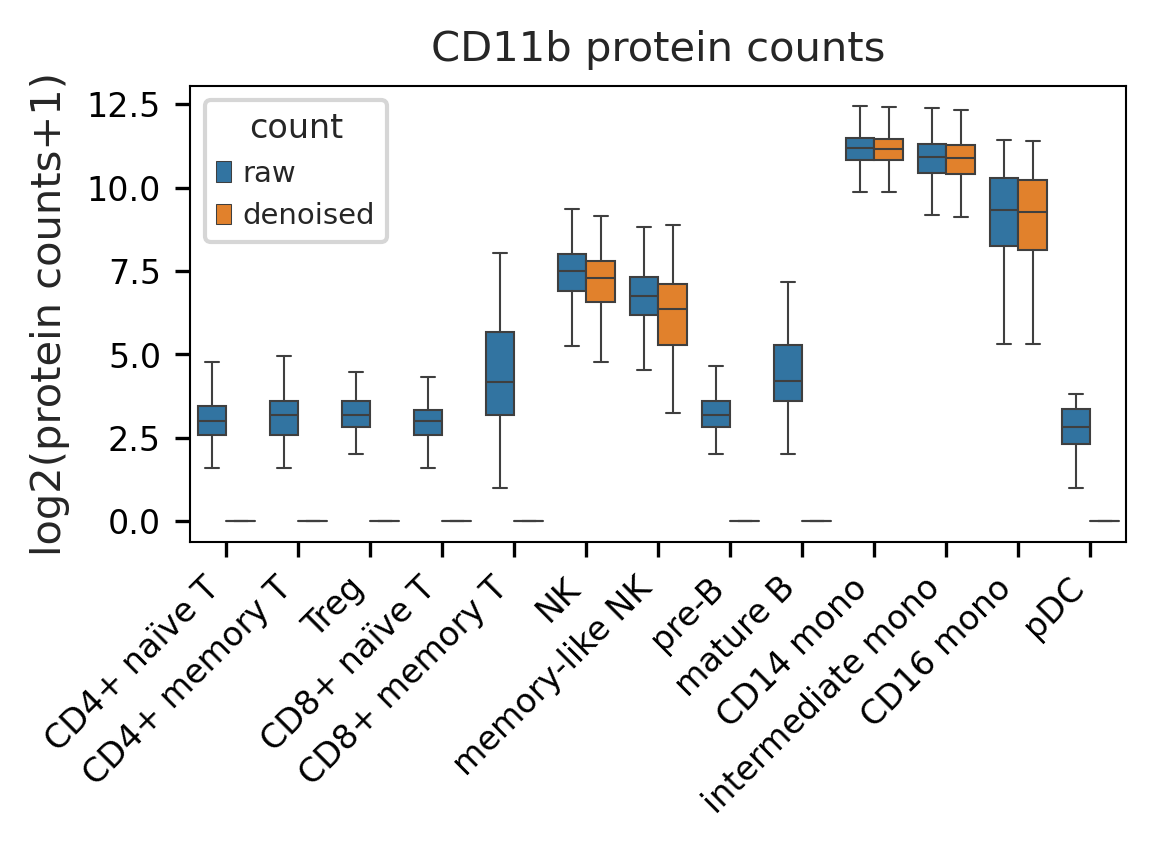

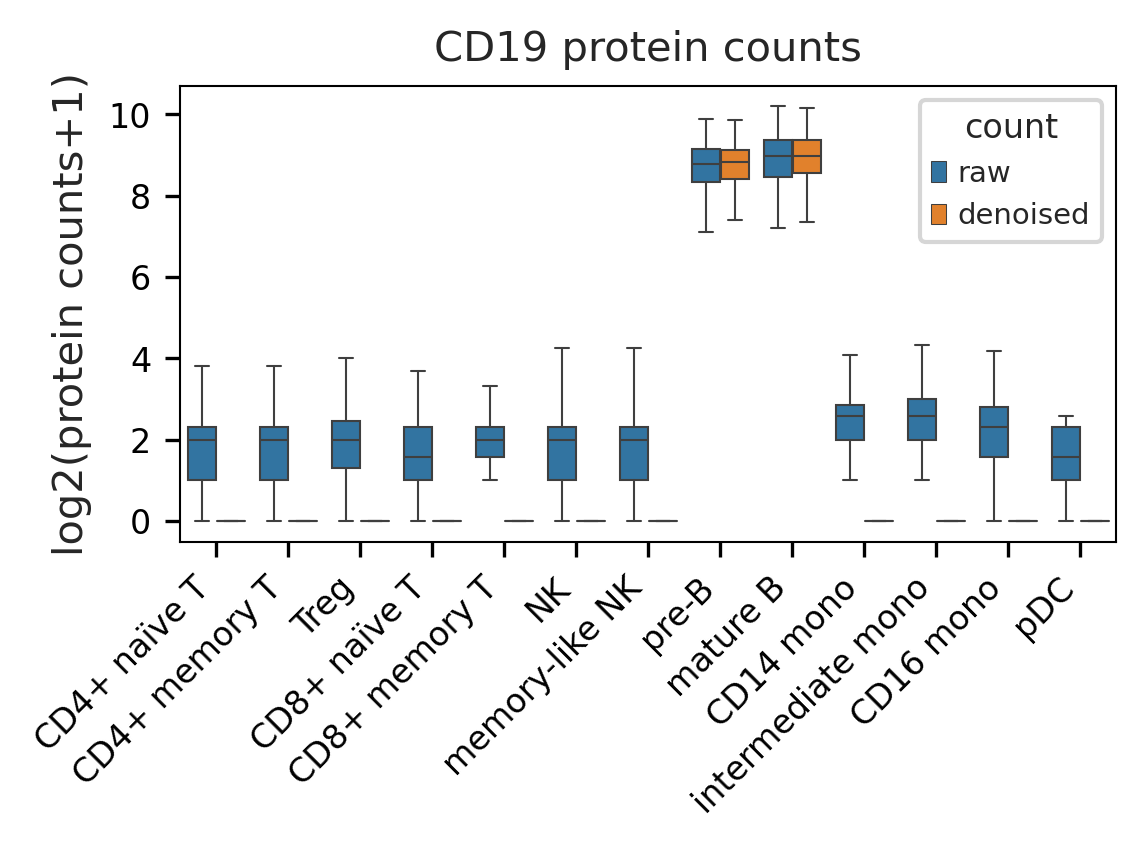

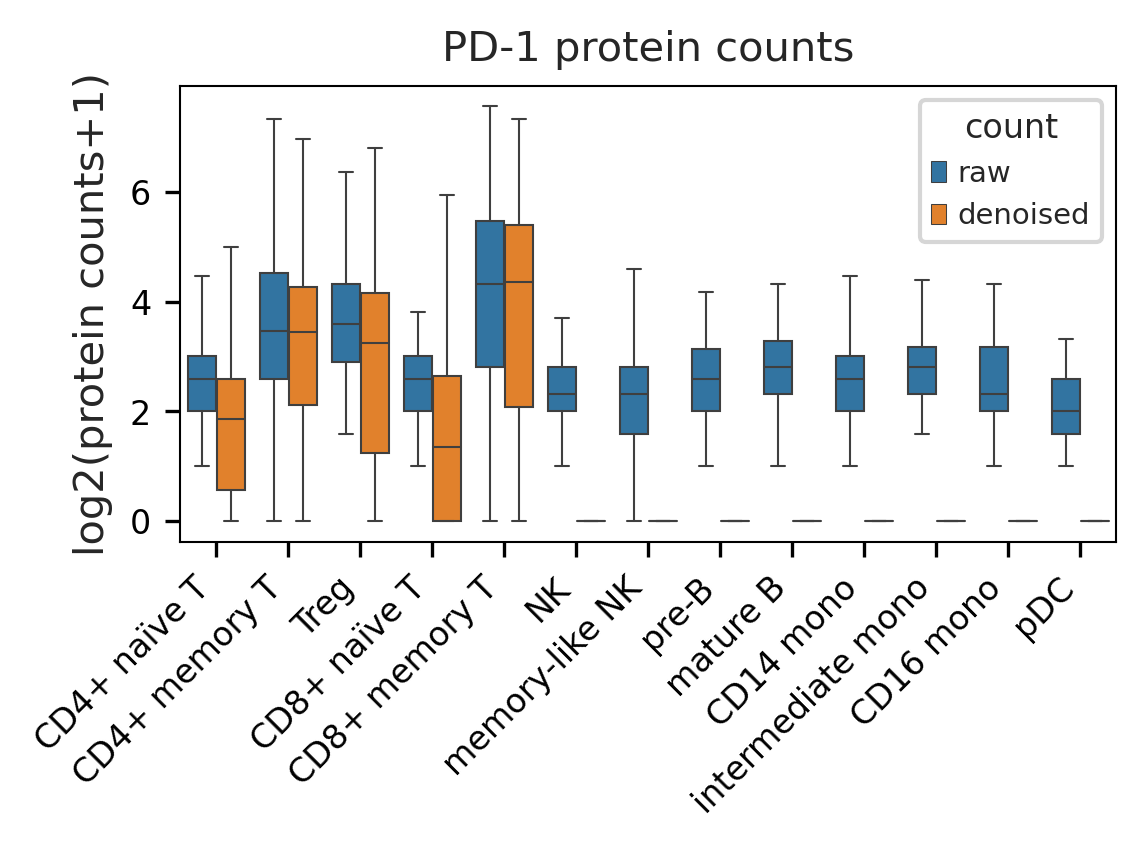

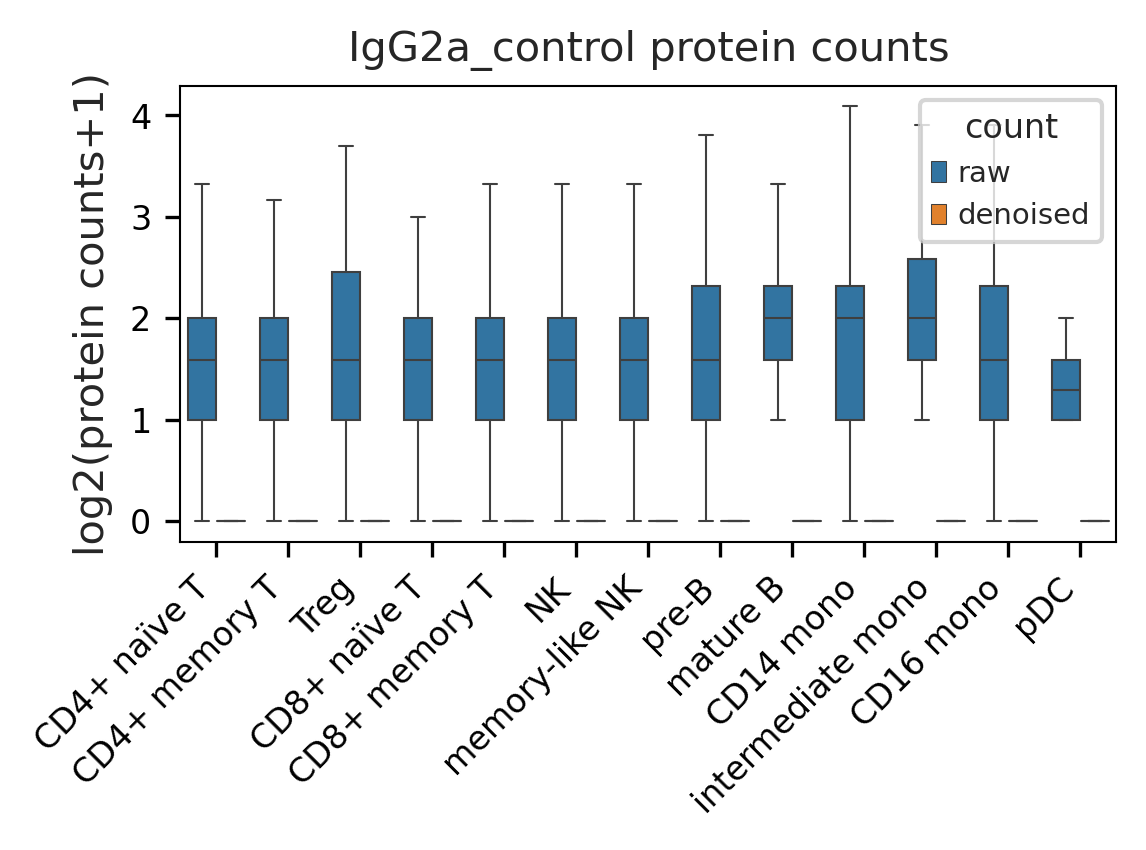

In [15]:
pylab.rcParams.update(params);

# Visualize several markers

for marker in ["CD3", "CD4", "CD8a", "CD11b", "CD19", "PD-1", "IgG2a_control"]:
    tmp = combined_ADTs[combined_ADTs['ADTs']==marker]
    plt.figure(figsize=(4, 2))
    g = sns.boxplot(x="celltype_1",
                    y="log2(counts+1)",
                    data=tmp,
                    hue="count",
                    hue_order=['raw', f'denoised'],
                    orient="v",
                    dodge=True,
                    width=0.8,
                    showfliers=False,
                    linewidth=0.5,
               );
    
    g.set(xlabel='', ylabel='log2(protein counts+1)', title=f'{marker} protein counts');
    g.set_xticklabels(g.get_xticklabels(),rotation=45, ha='right')

### UMAP visualization of ADT and RNA

In [11]:
mRNA_list = {'CD86': 'CD86',
             'CD274': 'CD274',
             'CD8a': 'CD8A',
             'CD56': 'CD56',
             'CD19': 'CD19',
             'CD45RA': 'PTPRC',
             'CD4': 'CD4',
             'CD14': 'CD14',
             'CD16': 'FCGR3A',
             'CD25': 'IL2RA',
             'CD45RO': 'PTPRC',
             'TIGIT': 'TIGIT',
             'CD20': 'MS4A1',
             'CD335': 'NCR1',
             'CD69': 'CD69',
             'CD62L': 'SELL',
             'CD197': 'CCR7',
             'CD27': 'CD27',
             'HLA-DR': 'HLA-DRA',
             'CD278': 'ICOS',
             'CD137': 'TNFRSF9',
             'CD28': 'CD28',
             'CD127': 'IL7R',
             'CD86': 'CD86',
             'CD274': 'CD274',
             'CD3': 'CD3D',
             'CD56': 'NCAM1',
             'CD19': 'CD19',
             'CD11b': 'ITGAM',
             'CD15': 'FUT4',
             'CD20': 'CCR7',
             'CD34': 'CD34',
             'CD80': 'CD80',
             'PD-1': 'PDCD1',
             'IgG1_control': 'IGHG1',
             'IgG2a_control': 'IGHG2',
             'IgG2b_control': 'IGHG2',
            }

for key in raw_ADT.columns:
    mRNA_list[key] = mRNA_list.pop(key)
mRNA = PBMCs5k[:, list(mRNA_list.values())].to_df()
mRNA.columns = mRNA.columns.astype(str)+'_RNA'

In [12]:
raw_ADT.columns = raw_ADT.columns.astype(str)+'_raw_protein'
denoised_ADT.columns = denoised_ADT.columns.astype(str)+'_denoised_protein'
PBMCs5k.obs = PBMCs5k.obs.join(mRNA).join(raw_ADT).join(denoised_ADT)

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


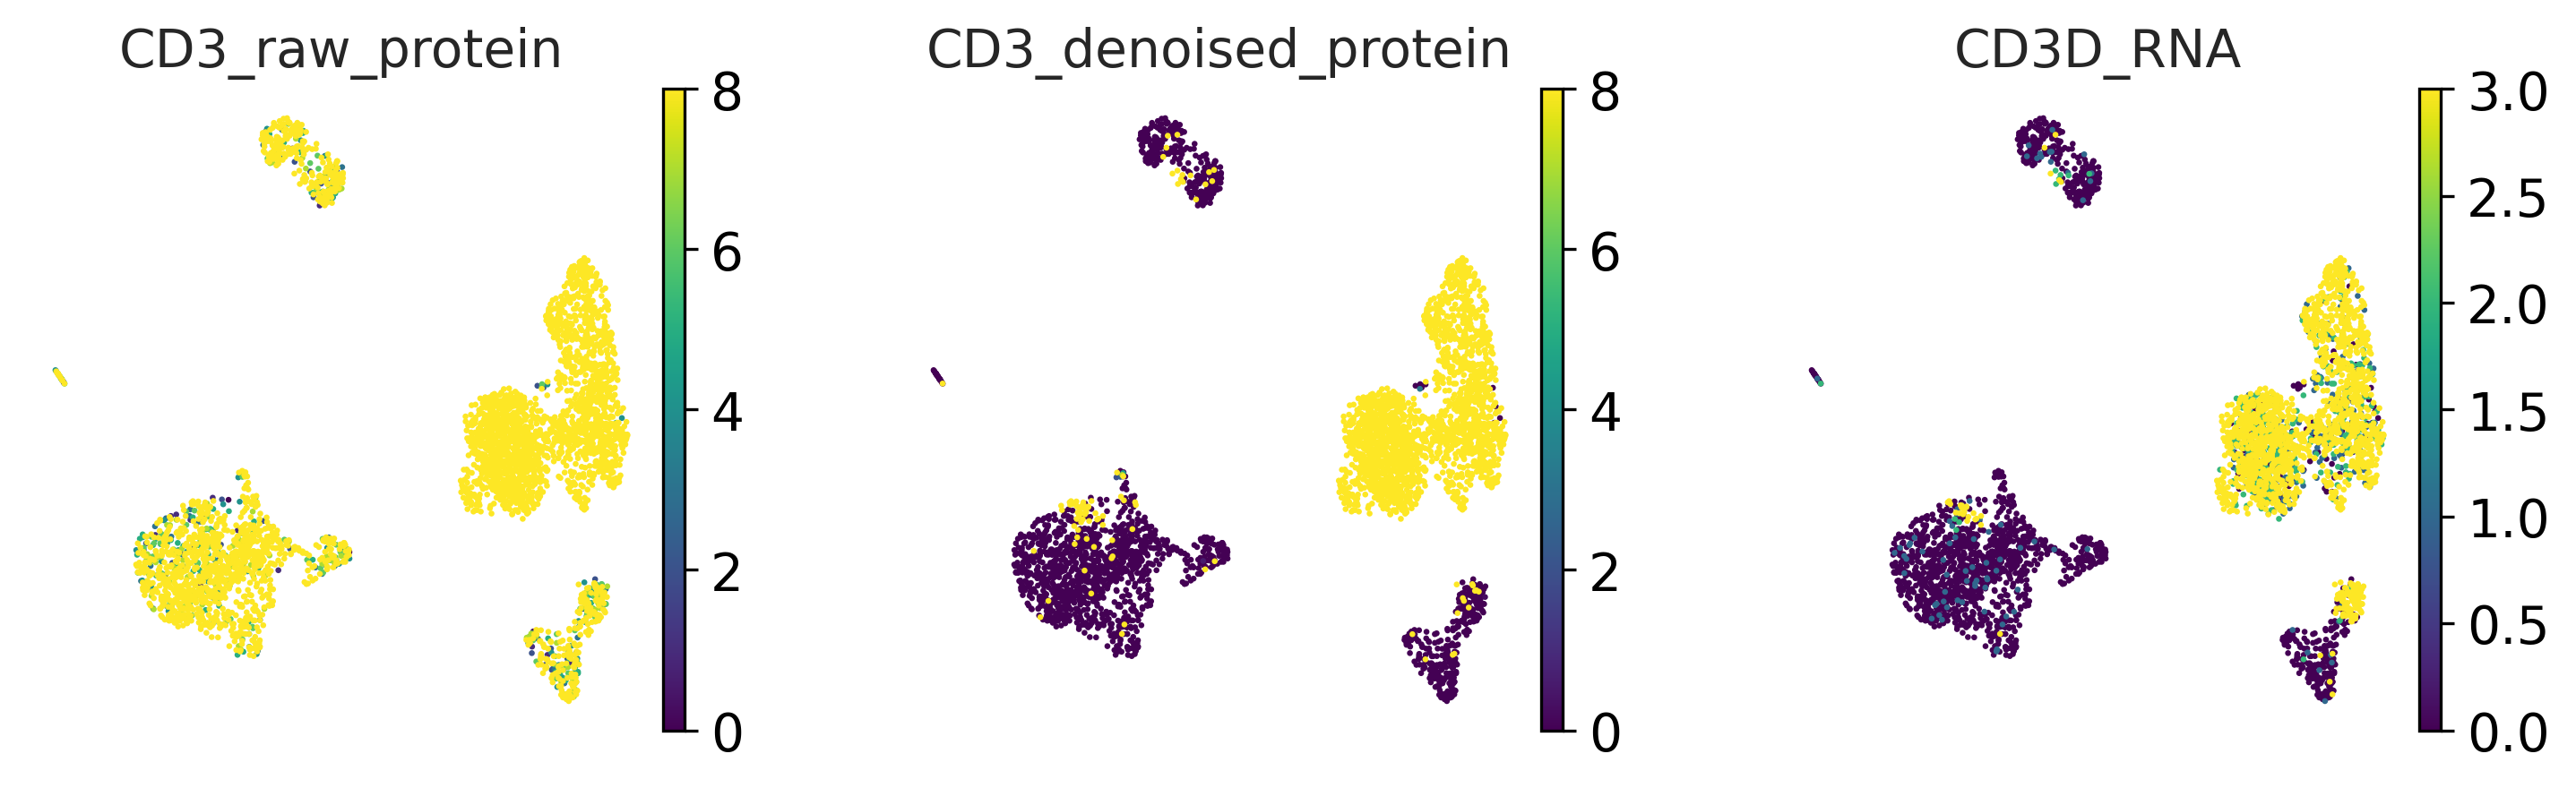

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


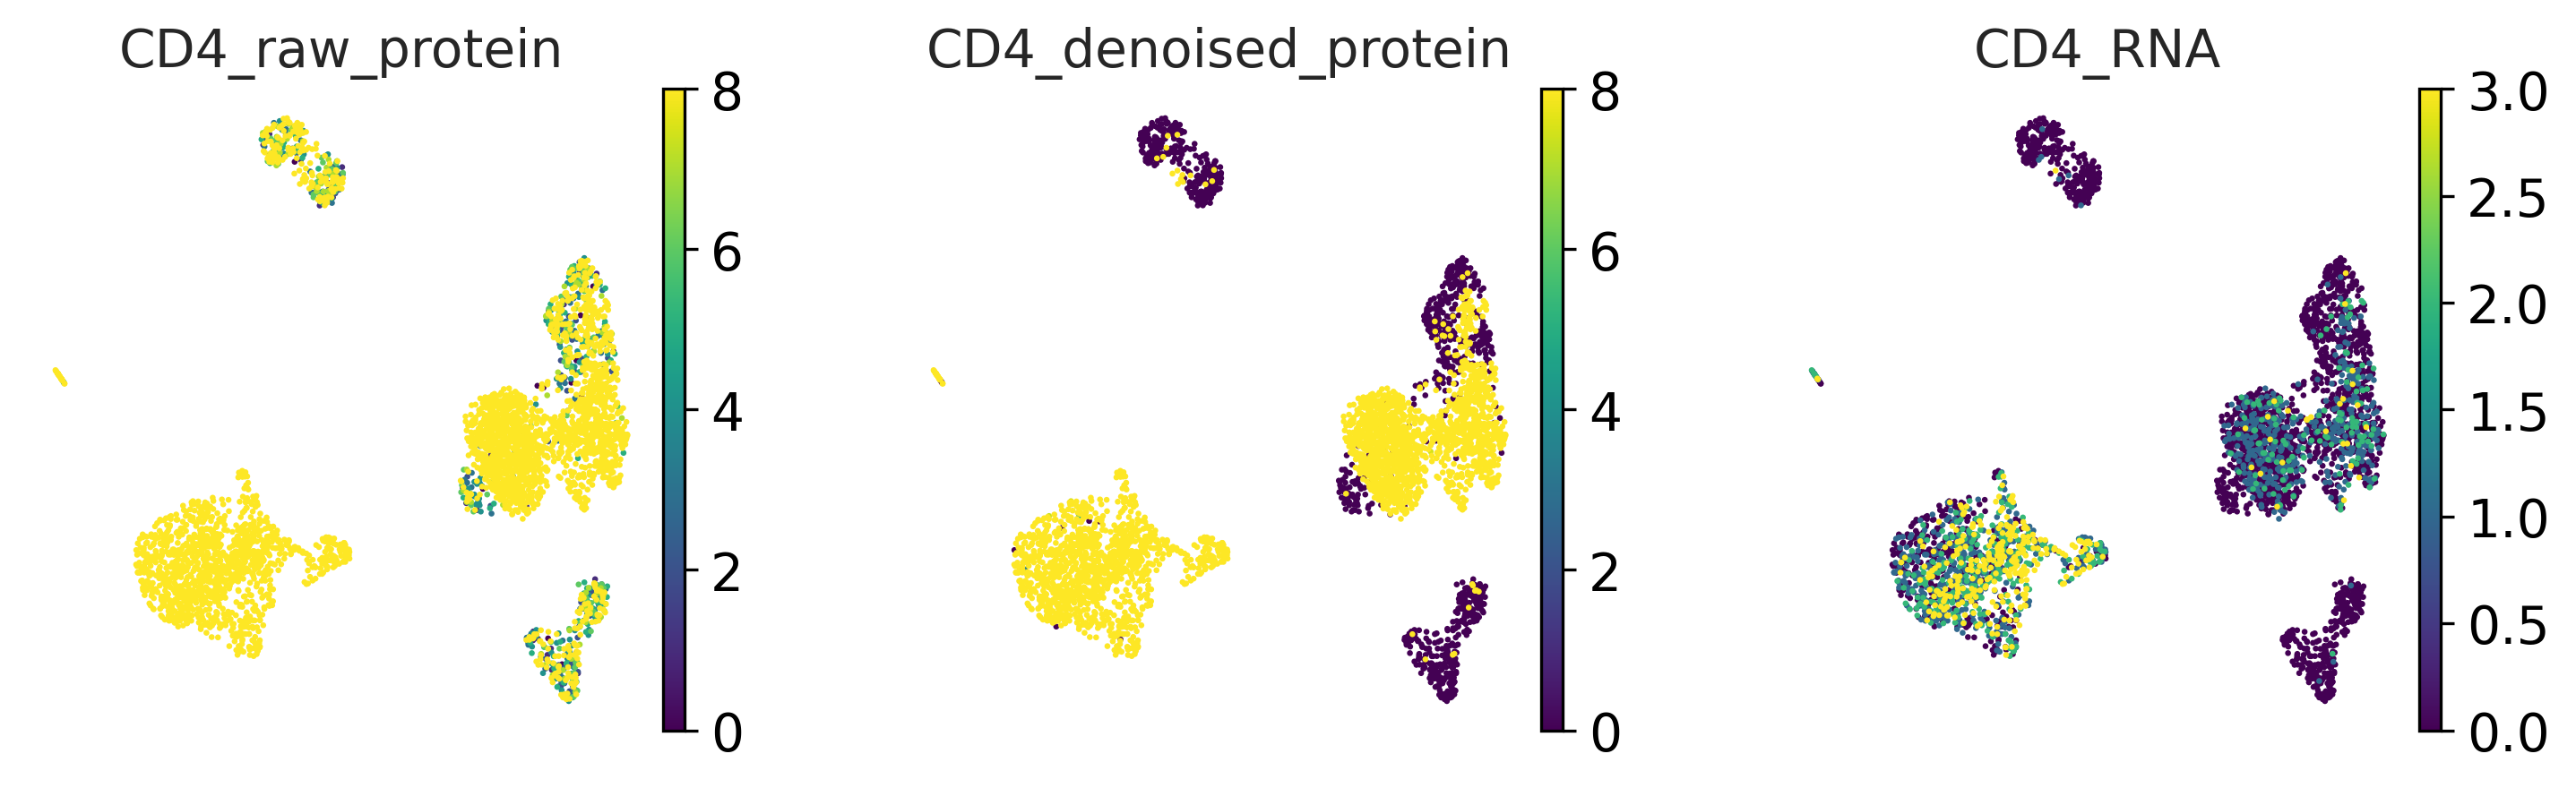

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


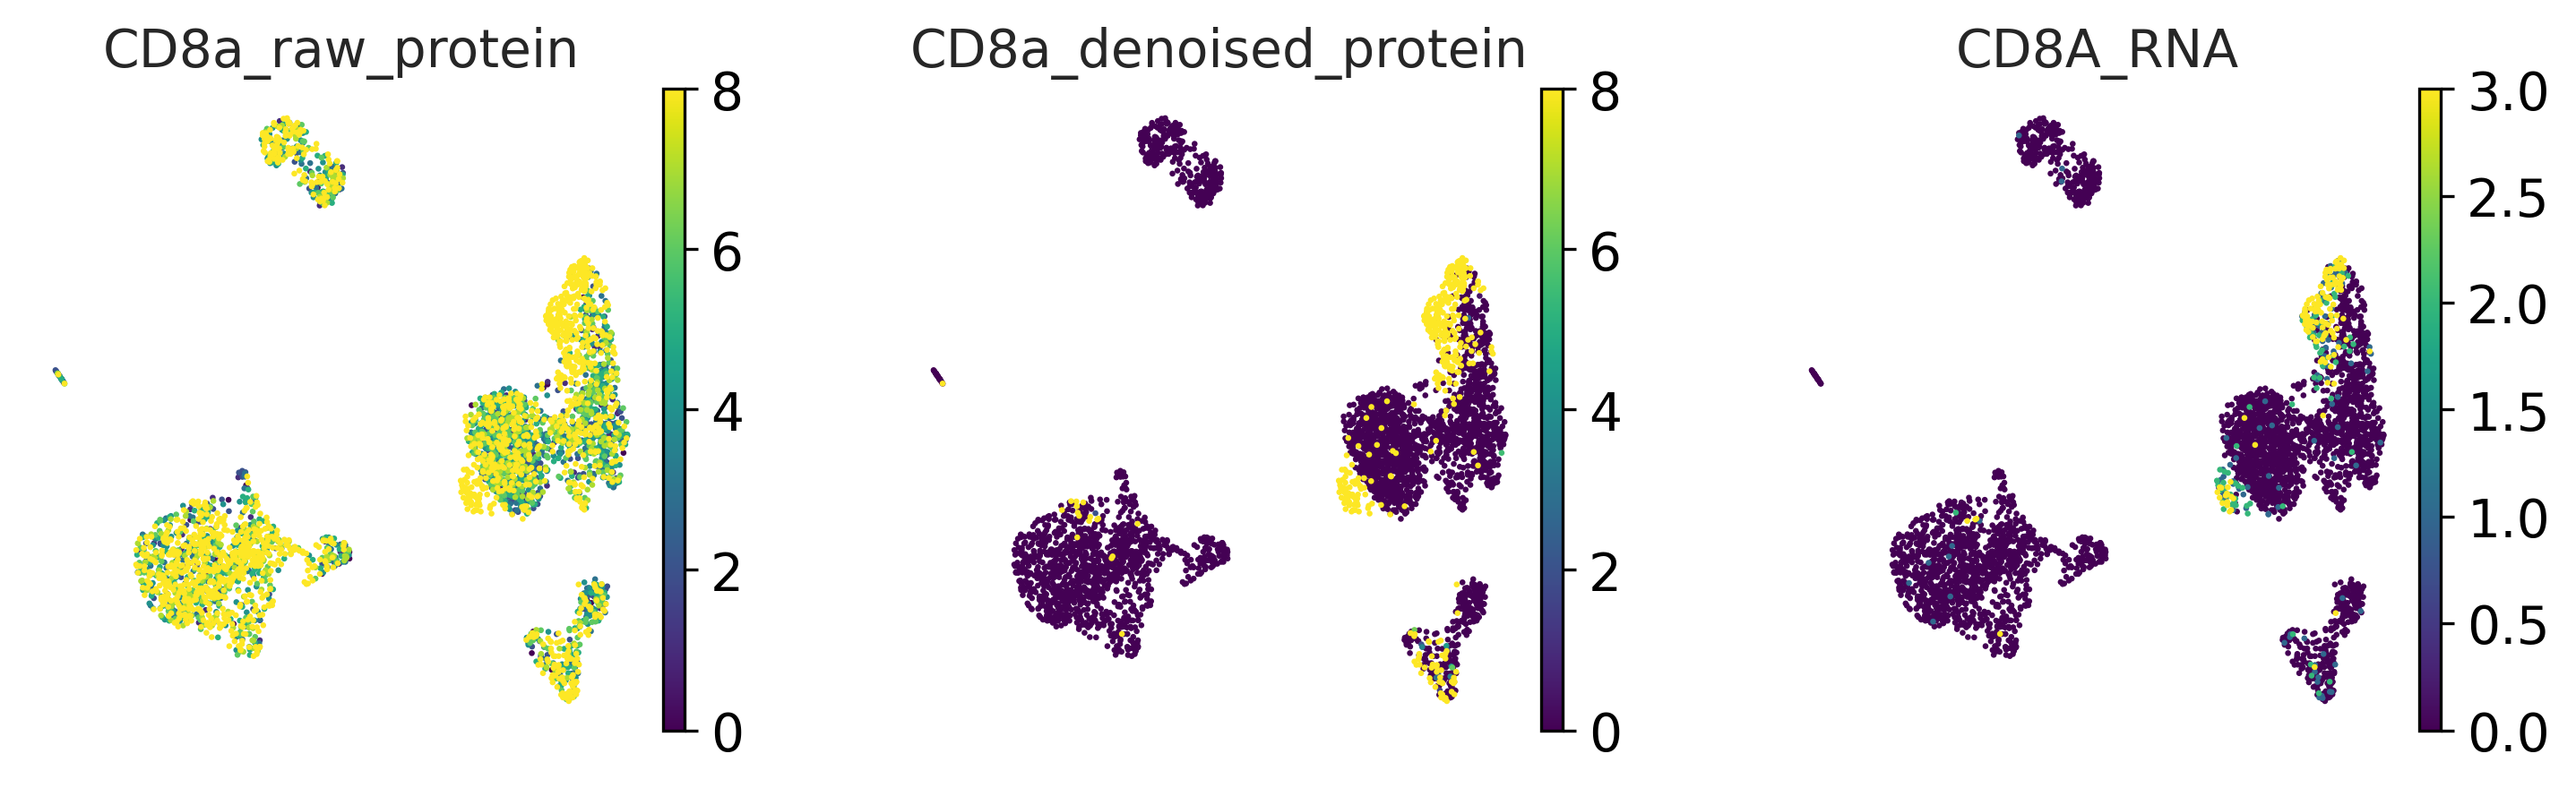

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


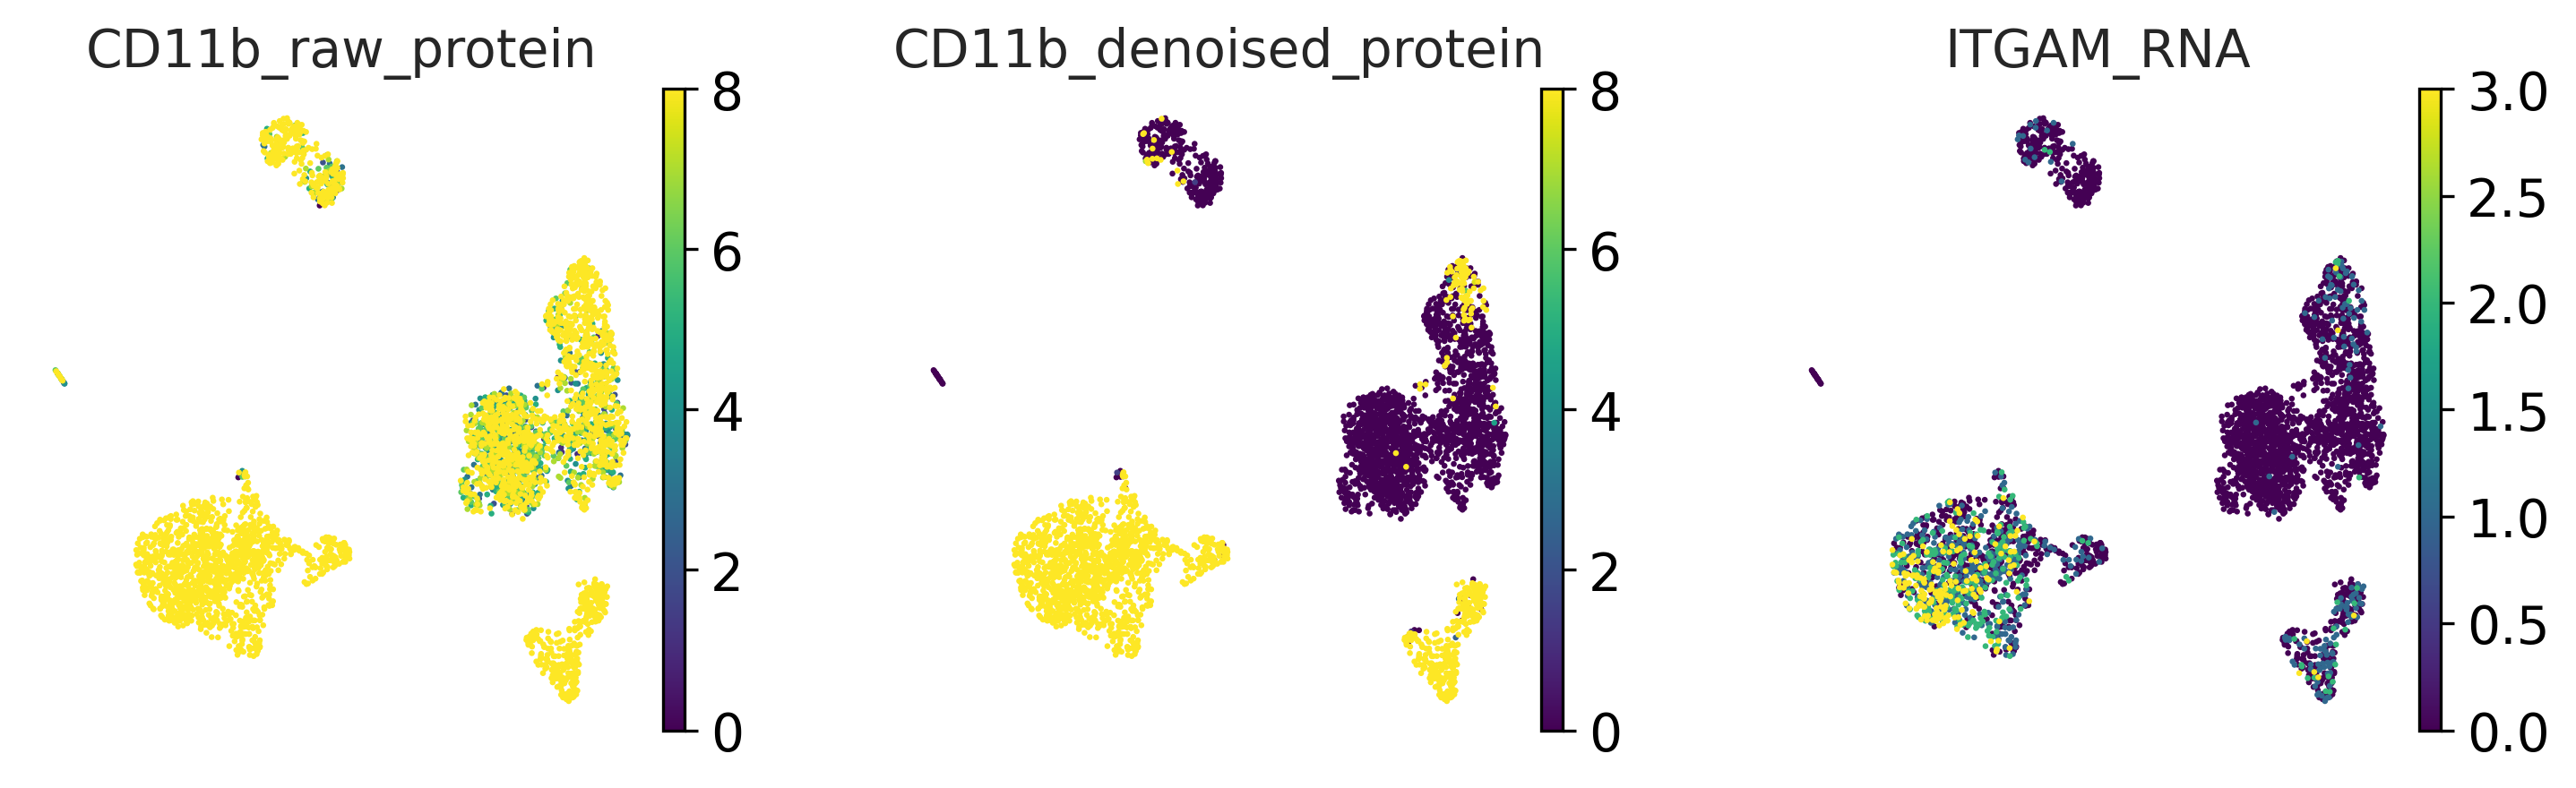

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


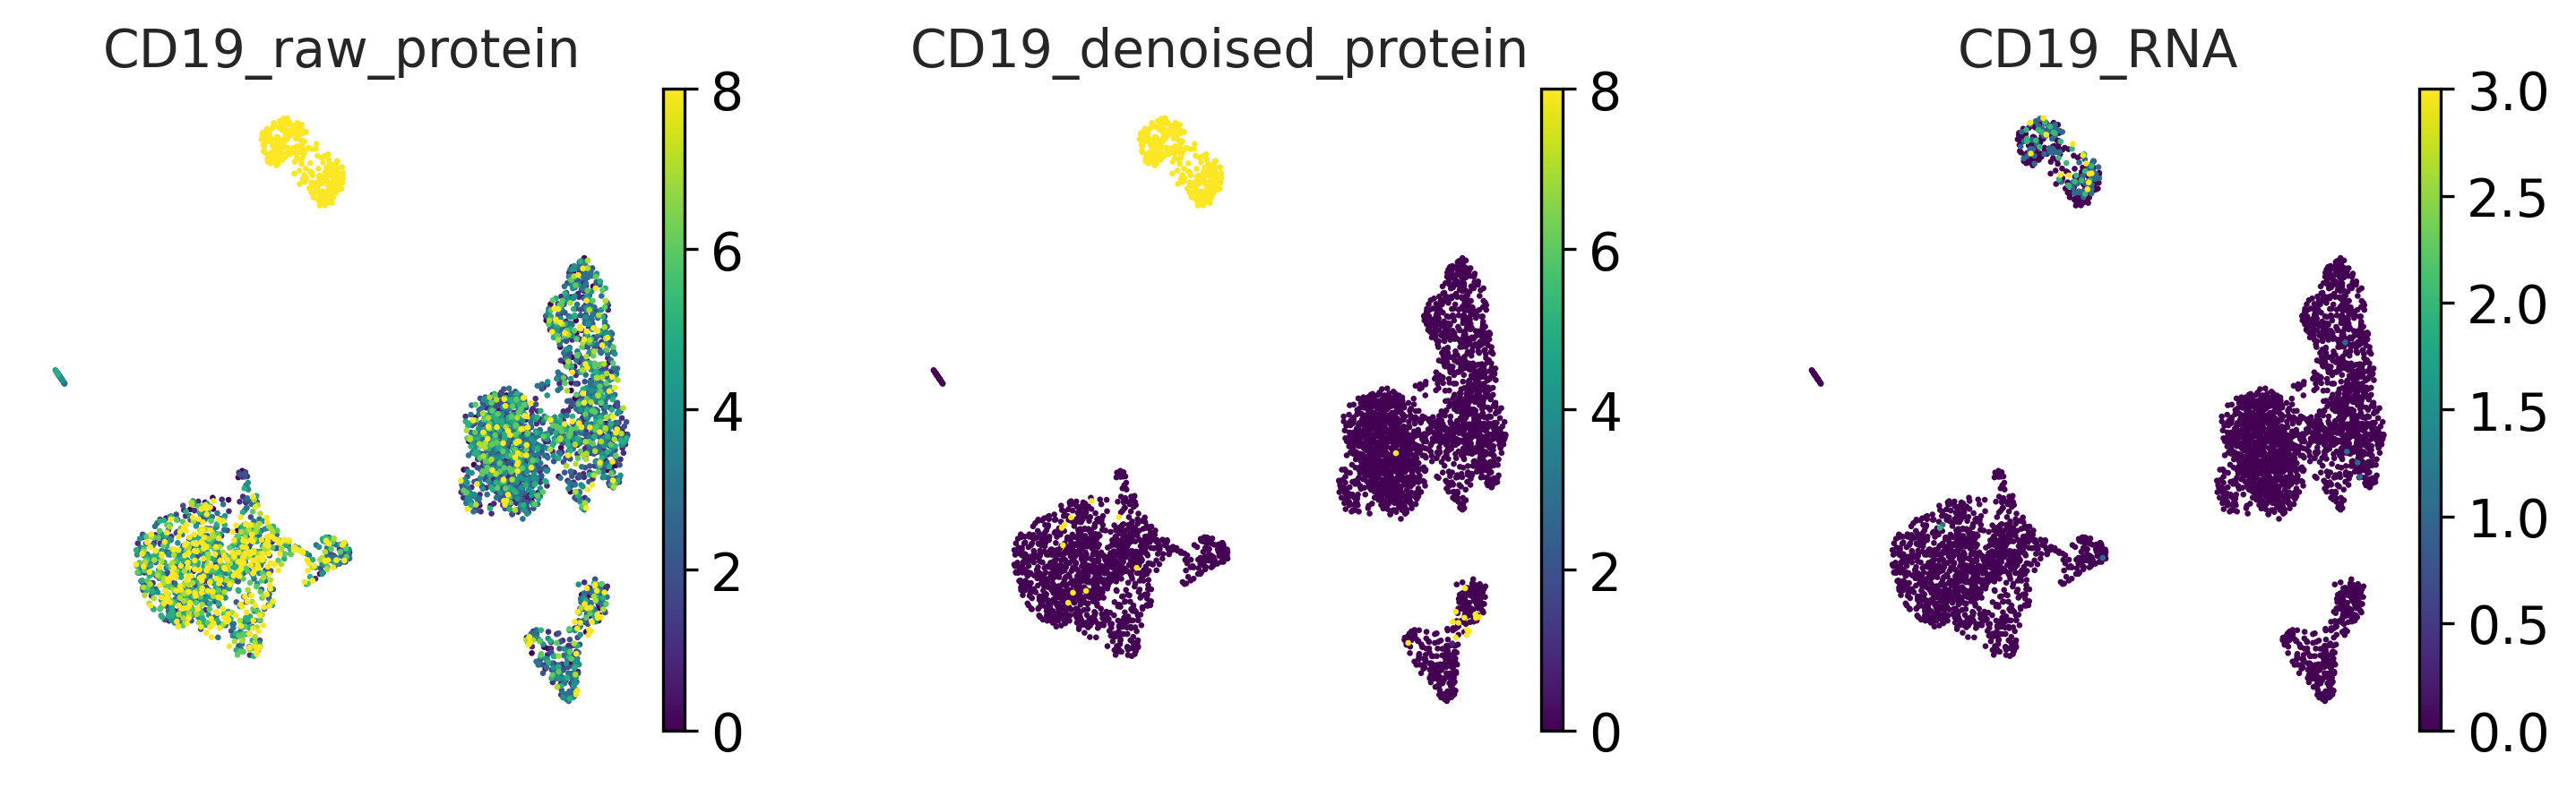

... storing 'CCR7_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'CCR7_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


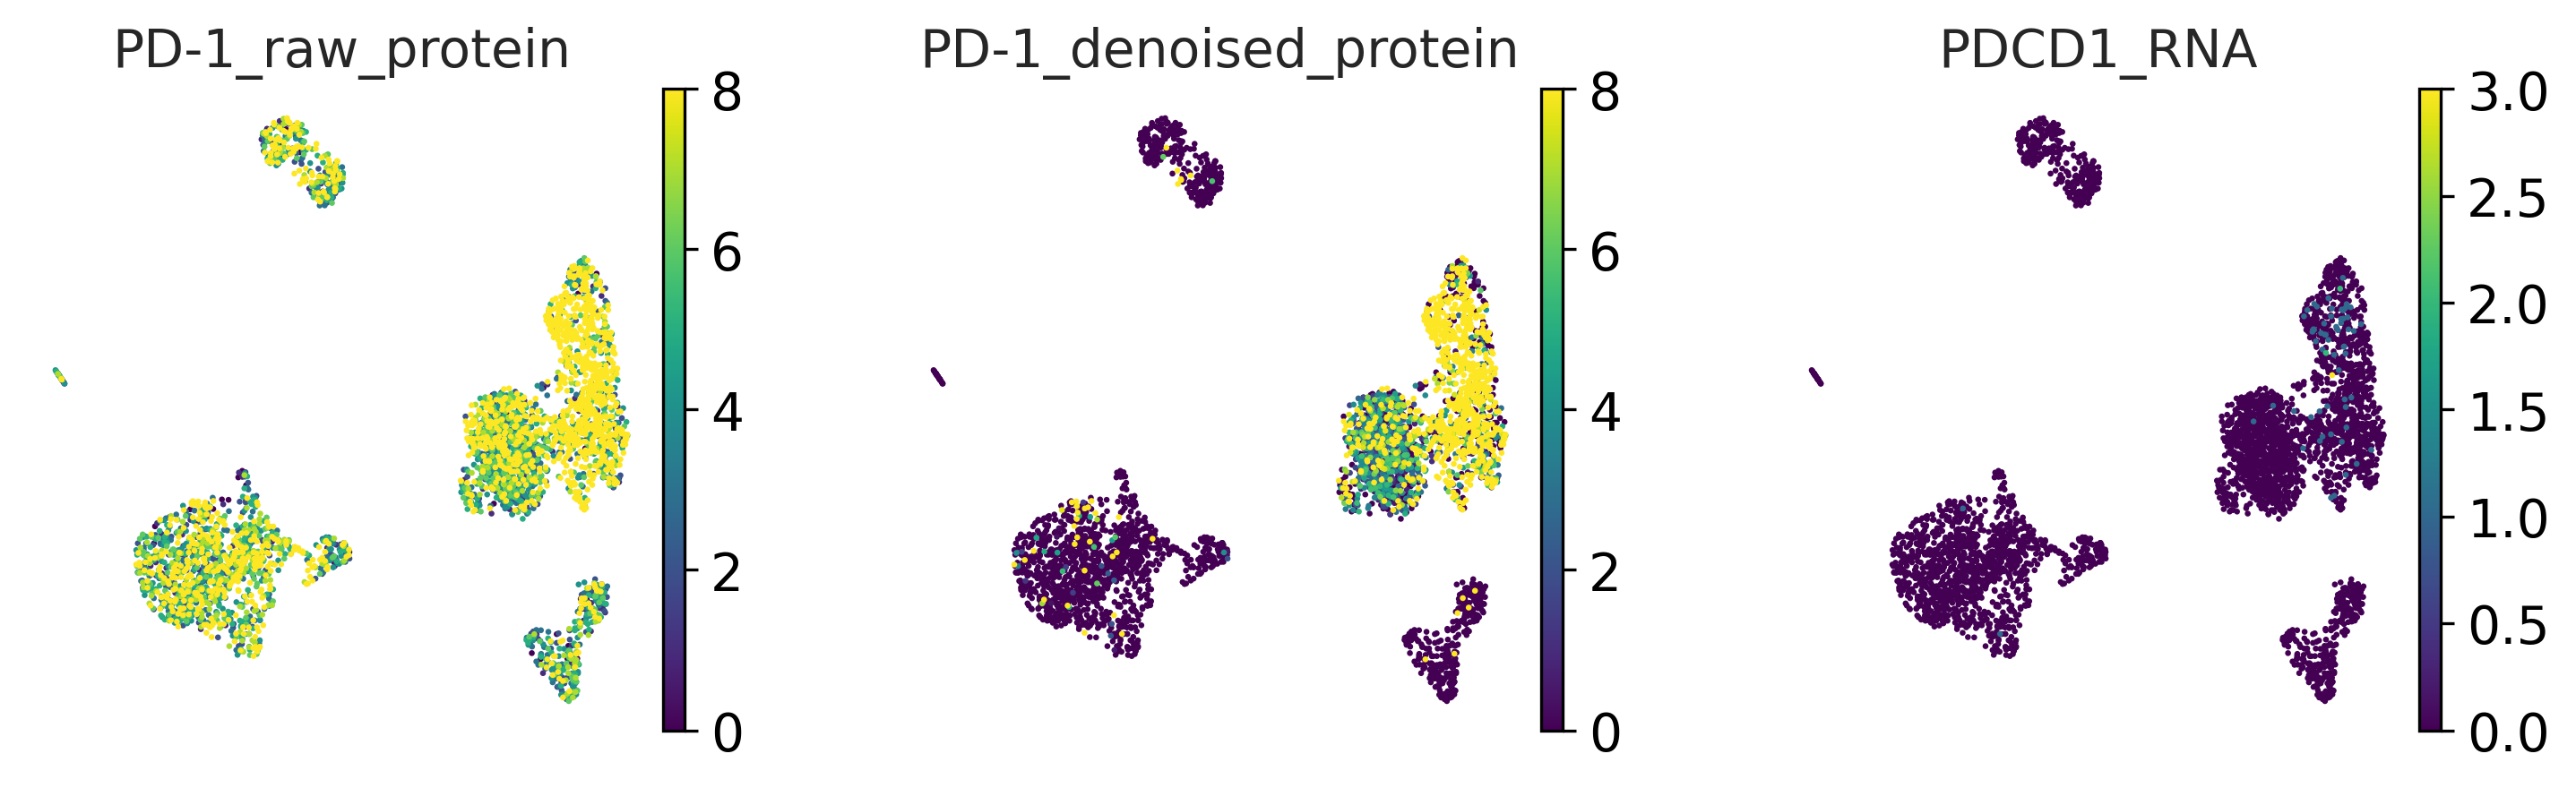

In [17]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3.1))
for marker in ["CD3", "CD4", "CD8a", "CD11b", "CD19", "PD-1"]:
    raw_prot_label = f'{marker}_raw_protein'
    denoised_prot_label = f'{marker}_denoised_protein'
    RNA_label = f'{mRNA_list[marker]}_RNA'
    sc.pl.umap(PBMCs5k,
               size=10,
               color=[raw_prot_label, denoised_prot_label, RNA_label],
               color_map="viridis",
               frameon=False,
               legend_loc="on data",
               legend_fontsize=5,
               vmax=[8, 8, 3],
               vmin=0, )